In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from collections import Counter
from openpyxl import load_workbook
from difflib import get_close_matches
import unicodedata


In [2]:
def fill_excel_from_result_df(
    result_df: pd.DataFrame,
    excel_path: str,
    output_path: str = None,
    target_model: str = None
):
    """
    Fills MSE and WAPE metrics for a target model into a structured Excel template.

    Parameters:
    - result_df: pd.DataFrame with ['group', 'pred_len', 'mse', 'wape', ...]
    - excel_path: path to input Excel file
    - output_path: path to save updated file (if None, will overwrite excel_path)
    - target_model: model name to update (must match one in row 1 of Excel)
    """
    # Normalize result_df columns and values
    result_df = result_df.copy()
    result_df.columns = result_df.columns.str.lower()
    result_df['group'] = result_df['group'].astype(str).str.strip().str.lower()
    result_df['pred_len'] = result_df['pred_len'].astype(int)

    wb = load_workbook(excel_path, data_only=True)
    ws = wb.active

    # === Step 1: Parse model headers ===
    model_col_map = {}
    for col in range(3, ws.max_column + 1, 2):
        raw_model = ws.cell(row=1, column=col).value
        if raw_model is None:
            continue

        model = unicodedata.normalize("NFKC", str(raw_model)).strip().lower()
        metric1 = ws.cell(row=2, column=col).value
        metric2 = ws.cell(row=2, column=col + 1).value

        model_col_map[model] = {}
        if metric1 and isinstance(metric1, str) and 'mse' in metric1.lower():
            model_col_map[model]['MSE'] = col
        if metric2 and isinstance(metric2, str) and 'wape' in metric2.lower():
            model_col_map[model]['WAPE'] = col + 1

    # === Step 2: Filter by model (if requested) ===
    if target_model:
        target_model_normalized = unicodedata.normalize("NFKC", target_model).strip().lower()
        if target_model_normalized not in model_col_map:
            suggestions = get_close_matches(target_model_normalized, model_col_map.keys(), n=3)
            raise ValueError(f"Model '{target_model}' not found. Did you mean: {suggestions}")
        model_col_map = {target_model_normalized: model_col_map[target_model_normalized]}

    # === Step 3: Fill metrics into Excel ===
    for row in range(3, ws.max_row + 1):
        # Handle pred_len as int regardless of Excel type
        pred_len_cell = ws.cell(row=row, column=2).value
        try:
            pred_len = int(float(pred_len_cell))
        except (TypeError, ValueError):
            continue

        group_cell = ws.cell(row=row, column=1).value
        if not isinstance(group_cell, str) or "_" not in group_cell:
            continue
        group = unicodedata.normalize("NFKC", group_cell).strip().lower()

        matched = result_df[(result_df['group'] == group) & (result_df['pred_len'] == pred_len)]
        if matched.empty:
            continue

        metrics = matched.iloc[0]
        metrics.index = metrics.index.str.lower()

        for model_name, col_map in model_col_map.items():
            for metric_key in ['MSE', 'WAPE']:
                df_key = metric_key.lower()
                if metric_key in col_map and df_key in metrics and pd.notna(metrics[df_key]):
                    ws.cell(row=row, column=col_map[metric_key], value=round(metrics[df_key], 6))

    # === Step 4: Save updated file ===
    save_path = output_path or excel_path
    wb.save(save_path)
    print(f"✅ Excel updated for model(s): {', '.join(model_col_map)}\nSaved to: {save_path}")


In [3]:

def show_results(root_dir):
    summary_results = []
    total_json_count = 0
    all_model_paths = []

    # === Traverse and summarize ===
    for group_dir in sorted(root_dir.iterdir()):
        if not group_dir.is_dir():
            continue

        metrics_list = []

        for subdir in group_dir.iterdir():
            if not subdir.is_dir():
                continue

            json_file = subdir / "results.json"
            if json_file.exists():
                total_json_count += 1
                with open(json_file, "r") as f:
                    data = json.load(f)
                    data["group"] = group_dir.name
                    metrics_list.append(data)
                    all_model_paths.append(data.get("model_path", "unknown"))

        if metrics_list:
            df = pd.DataFrame(metrics_list)
            df_mean = df.drop(columns=["dataset", "freq", "model_path"]).mean(numeric_only=True)
            df_mean["group"] = group_dir.name
            summary_results.append(df_mean)

    # === Combine summaries ===
    summary_df = pd.DataFrame(summary_results)
    summary_df.sort_values("group", inplace=True)

    # === Display summary table ===
    print("\n📊 Summary of Mean Metrics per Dataset Group:")
    display(summary_df)

    # === Compute overall global mean across all groups ===
    global_means = summary_df.drop(columns=["group"]).mean(numeric_only=True)
    print("\n📌 Global Mean Across All Groups:")
    print(global_means.round(4))

    # === Determine model name to display in title ===
    model_name = Counter(all_model_paths).most_common(1)[0][0] if all_model_paths else "Unknown Model"

    # === Visualization ===
    plt.figure(figsize=(12, 6))
    for metric in ["mse", "mae", "smape", "wape", "nrmse"]:
        if metric in summary_df.columns:
            plt.plot(summary_df["group"], summary_df[metric], marker='o', label=metric)

    plt.xticks(rotation=45)
    plt.xlabel("Dataset Group")
    plt.ylabel("Metric Value")
    plt.title(f"Average Forecasting Metrics by Dataset Group\nModel: {model_name} pred len: {summary_df['pred_len'][0]} context len: {summary_df['context_len'][0]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Total json count ===
    print(f"\n🔢 Total number of results.json files found: {total_json_count}")

    return summary_df

In [4]:
excel_file_path = r'C:\Users\11320\OneDrive\AI\ffm_sync\Zeroshot results - test.xlsx'
wb = load_workbook(excel_file_path)
ws = wb.active
# Parse all model name columns
model_col_map = {}
for col in range(3, ws.max_column + 1, 2):
    model = ws.cell(row=1, column=col).value
    if model is None:
        continue
    model = model.strip()
    model_col_map[model] = {
        'MSE': col,
        'WAPE': col + 1,
    }

print("Available models in Excel headers:", list(model_col_map.keys()))

def print_excel_sheet_contents(excel_path, sheet_name=None):
    wb = load_workbook(excel_path, data_only=True)
    ws = wb[sheet_name] if sheet_name else wb.active

    print("=== Excel Sheet Content ===")
    for row in ws.iter_rows(values_only=True):
        print(row)

print_excel_sheet_contents(excel_file_path)


Available models in Excel headers: ['FTFM hbcft_v3t_ep3', 'TimesFM 200M', 'TimesFM 500M', 'Chronos small', 'Chronos Medium', 'Chronos Large']
=== Excel Sheet Content ===
('Models', None, 'FTFM hbcft_v3t_ep3', None, 'TimesFM 200M', None, 'TimesFM 500M', None, 'Chronos small', None, 'Chronos Medium', None, 'Chronos Large', None, None, None, None, None, None, None, None, None, None)
('Metrics', None, 'MSE', 'WAPE', 'MSE', 'WAPE', 'MSE', 'WAPE', 'MSE', 'WAPE', 'MSE', 'WAPE', 'MSE', 'WAPE', None, None, None, None, None, None, None, None, None)
('crypto10_1d', 10, None, None, 0.092608, 0.182649, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
('crypto10_1d', 20, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'Chronos = Chronos T5', None)
('crypto10_1d', 30, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

## TimesFM 200m


📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.092608,0.255055,0.138591,0.182649,0.390547,3693.333333,2888.451090,3.994347,10.0,128.0,crypto10_1d
1,0.012949,0.172356,0.066786,0.076747,0.130814,20880.000000,18160.546875,22.872678,10.0,128.0,crypto10_1h
2,0.019192,0.194858,0.076654,0.091778,0.166112,8853.333333,7392.073730,10.196857,10.0,128.0,crypto10_1m
3,0.060080,0.235827,0.135246,0.151250,0.262754,6920.000000,6179.074219,7.546202,10.0,128.0,forex_datasets_1d
4,0.018419,0.185430,0.080419,0.095245,0.156918,20720.000000,17725.246745,23.275421,10.0,128.0,forex_datasets_1h
5,0.054268,0.261148,0.129388,0.149344,0.254971,12200.000000,10563.588867,13.754068,10.0,128.0,forex_datasets_1m
6,0.422649,0.710717,0.408444,0.524546,0.835369,2040.000000,1600.562581,2.217127,10.0,128.0,forex_datasets_1wk
7,0.077344,0.345456,0.133580,0.177281,0.364478,7280.000000,5514.909912,8.090483,10.0,128.0,futures_datasets_1d
8,0.021575,0.154593,0.076712,0.086801,0.166202,16160.000000,14281.680664,17.855382,10.0,128.0,futures_datasets_1h
9,0.192662,0.347075,0.200278,0.242223,0.381411,9140.000000,7848.489827,10.493158,10.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.1265
smape              0.3340
mae                0.1748
wape               0.2135
nrmse              0.3725
num_elements    8522.8290
abs_sum         7245.6648
total_time         9.5985
pred_len          10.0000
context_len      128.0000
dtype: float64


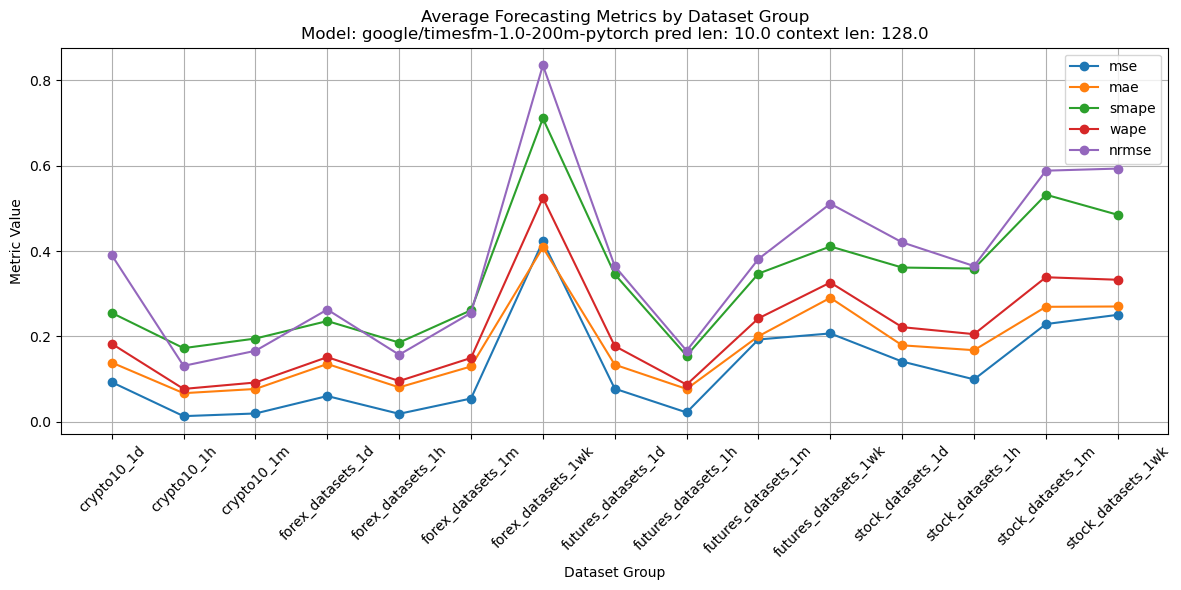


🔢 Total number of results.json files found: 908
✅ Excel updated for model(s): timesfm 200m
Saved to: C:\Users\11320\OneDrive\AI\ffm_sync\Zeroshot results - test.xlsx


In [5]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_200m_of1\h10")
summary_df = show_results(root_dir)

#data load into excel
target_model = "TimesFM 200M"
fill_excel_from_result_df(summary_df, excel_path=excel_file_path, output_path=excel_file_path, target_model=target_model)


📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.188394,0.334150,0.202652,0.268382,0.561755,3653.333333,2840.513428,1.161069,20.0,128.0,crypto10_1d
1,0.022497,0.218380,0.091526,0.105182,0.172451,20880.000000,18160.557617,6.577403,20.0,128.0,crypto10_1h
2,0.044851,0.254009,0.118202,0.141793,0.253876,8853.333333,7392.073242,2.764555,20.0,128.0,crypto10_1m
3,0.104252,0.321491,0.194477,0.217566,0.350702,6920.000000,6179.074707,2.385353,20.0,128.0,forex_datasets_1d
4,0.036663,0.246061,0.117000,0.138566,0.221180,20693.333333,17704.054688,6.741689,20.0,128.0,forex_datasets_1h
5,0.093660,0.327263,0.173241,0.200199,0.332143,12160.000000,10519.006510,4.098102,20.0,128.0,forex_datasets_1m
6,0.829629,0.919822,0.610918,0.787282,1.175640,2000.000000,1563.865031,0.724654,20.0,128.0,forex_datasets_1wk
7,0.163540,0.458918,0.199860,0.266064,0.533969,7240.000000,5461.366089,2.383881,20.0,128.0,futures_datasets_1d
8,0.042121,0.217544,0.115100,0.130238,0.232227,16160.000000,14281.685547,5.438113,20.0,128.0,futures_datasets_1h
9,0.222697,0.396909,0.235595,0.283884,0.446315,9120.000000,7832.895752,3.067882,20.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.2346
smape              0.4333
mae                0.2501
wape               0.3071
nrmse              0.5161
num_elements    8500.5135
abs_sum         7219.2052
total_time         2.7999
pred_len          20.0000
context_len      128.0000
dtype: float64


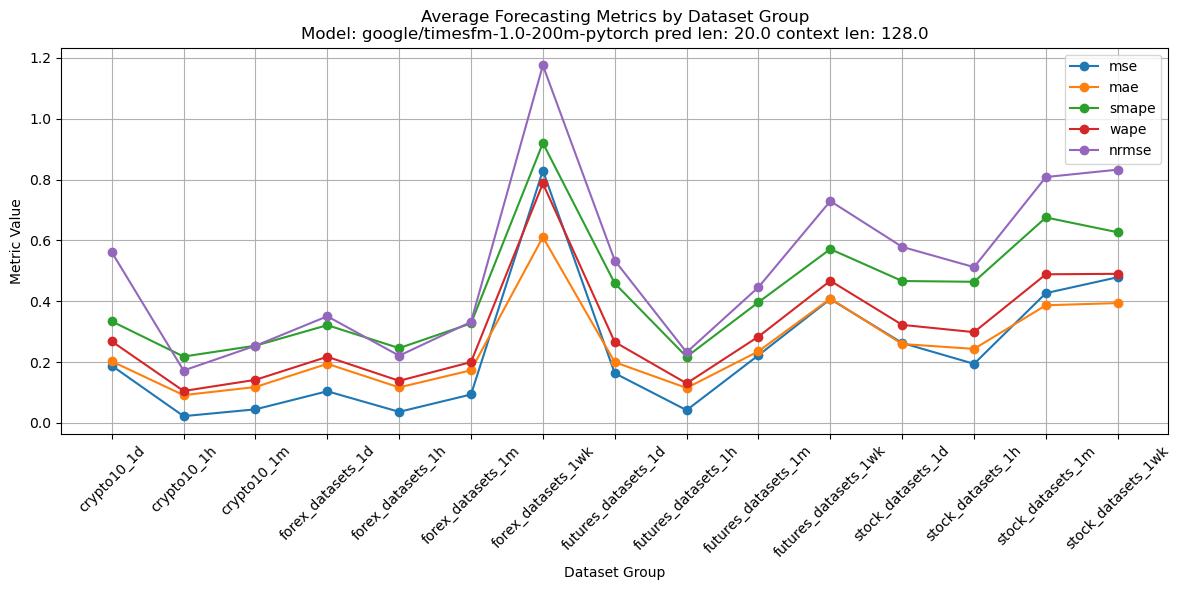


🔢 Total number of results.json files found: 908
✅ Excel updated for model(s): timesfm 200m
Saved to: C:\Users\11320\OneDrive\AI\ffm_sync\Zeroshot results - test.xlsx


In [6]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_200m_of1\h20")
show_results(root_dir)

#data load into excel
target_model = "TimesFM 200M"
fill_excel_from_result_df(summary_df, excel_path=excel_file_path, output_path=excel_file_path, target_model=target_model)


📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.290396,0.416169,0.265617,0.349766,0.696722,3680.000000,2867.131429,1.374428,30.0,128.0,crypto10_1d
1,0.033788,0.269520,0.115124,0.132307,0.211345,20880.000000,18160.559570,7.708606,30.0,128.0,crypto10_1h
2,0.068893,0.308458,0.146914,0.177035,0.316151,8800.000000,7310.747884,3.229276,30.0,128.0,crypto10_1m
3,0.159889,0.371515,0.242575,0.271295,0.436443,6900.000000,6164.434570,2.486581,30.0,128.0,forex_datasets_1d
4,0.055844,0.292803,0.145570,0.173330,0.273048,20640.000000,17603.581380,7.631246,30.0,128.0,forex_datasets_1h
5,0.148448,0.414046,0.229119,0.265029,0.421811,12120.000000,10474.398112,4.458304,30.0,128.0,forex_datasets_1m
6,1.096010,0.990230,0.725844,0.934296,1.350439,2040.000000,1600.562541,0.780504,30.0,128.0,forex_datasets_1wk
7,0.231276,0.523705,0.243088,0.324017,0.635384,7200.000000,5408.967285,2.595062,30.0,128.0,futures_datasets_1d
8,0.064120,0.283257,0.149996,0.169488,0.286126,16080.000000,14230.698242,5.846544,30.0,128.0,futures_datasets_1h
9,0.261452,0.453337,0.275724,0.331327,0.507703,9080.000000,7780.715047,3.336322,30.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.3378
smape              0.5031
mae                0.3123
wape               0.3824
nrmse              0.6236
num_elements    8482.6778
abs_sum         7197.0067
total_time         3.1544
pred_len          30.0000
context_len      128.0000
dtype: float64


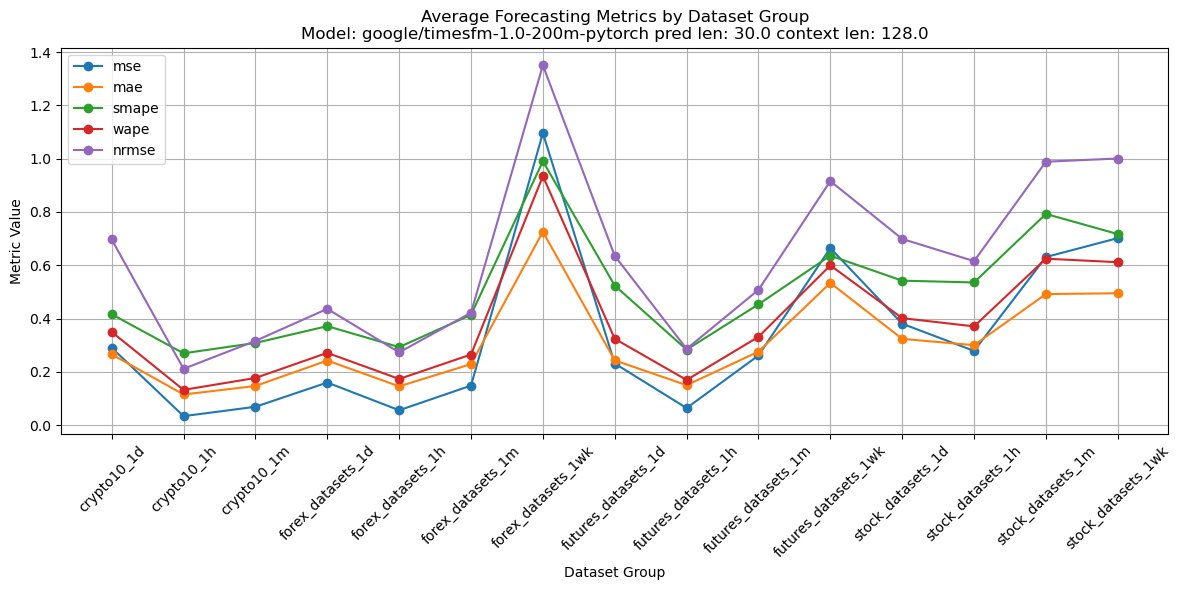


🔢 Total number of results.json files found: 908
✅ Excel updated for model(s): timesfm 200m
Saved to: C:\Users\11320\OneDrive\AI\ffm_sync\Zeroshot results - test.xlsx


In [7]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_200m_of1\h30")
show_results(root_dir)

#data load into excel
target_model = "TimesFM 200M"
fill_excel_from_result_df(summary_df, excel_path=excel_file_path, output_path=excel_file_path, target_model=target_model)


📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.571246,0.562221,0.397239,0.532316,0.998509,3600.000000,2775.409180,0.453118,60.0,128.0,crypto10_1d
1,0.073083,0.350614,0.172273,0.197989,0.310806,20880.000000,18160.557617,2.235666,60.0,128.0,crypto10_1h
2,0.154666,0.420995,0.233014,0.280693,0.473637,8800.000000,7310.747721,0.949188,60.0,128.0,crypto10_1m
3,0.302304,0.508109,0.357625,0.398764,0.591901,6840.000000,6124.638184,0.894300,60.0,128.0,forex_datasets_1d
4,0.111372,0.384621,0.211209,0.251078,0.386633,20560.000000,17539.440104,2.221624,60.0,128.0,forex_datasets_1h
5,0.288762,0.529443,0.328838,0.381547,0.595482,12000.000000,10344.388346,1.286513,60.0,128.0,forex_datasets_1m
6,1.743990,1.207815,0.953391,1.235216,1.704435,1920.000000,1488.001546,0.262985,60.0,128.0,forex_datasets_1wk
7,0.499516,0.658212,0.369096,0.498342,0.951142,7080.000000,5251.835938,0.808788,60.0,128.0,futures_datasets_1d
8,0.120162,0.355682,0.209828,0.237095,0.391690,16080.000000,14230.702148,2.003497,60.0,128.0,futures_datasets_1h
9,0.344902,0.542962,0.349299,0.416965,0.624160,9000.000000,7713.614176,1.057334,60.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.6180
smape              0.6470
mae                0.4484
wape               0.5550
nrmse              0.8634
num_elements    8412.9351
abs_sum         7119.8149
total_time         0.9629
pred_len          60.0000
context_len      128.0000
dtype: float64


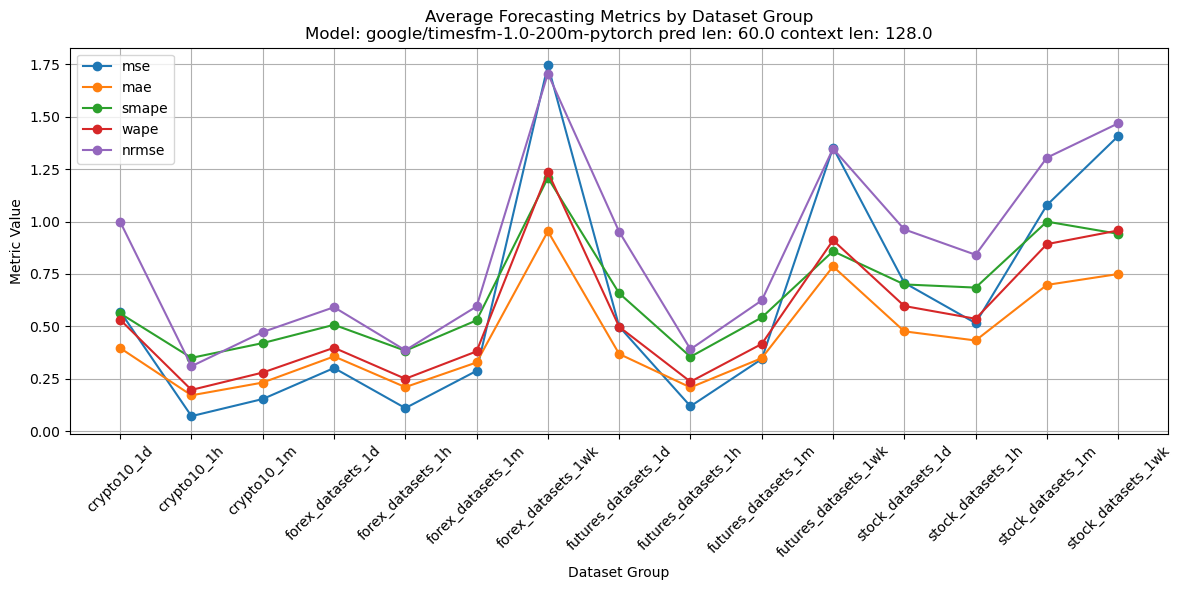


🔢 Total number of results.json files found: 908
✅ Excel updated for model(s): timesfm 200m
Saved to: C:\Users\11320\OneDrive\AI\ffm_sync\Zeroshot results - test.xlsx


In [8]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_200m_of1\h60")
show_results(root_dir)

#data load into excel
target_model = "TimesFM 200M"
fill_excel_from_result_df(summary_df, excel_path=excel_file_path, output_path=excel_file_path, target_model=target_model)


📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.878540,0.699590,0.539230,0.733351,1.232452,3584.000000,2755.319255,0.455593,96.0,128.0,crypto10_1d
1,0.108872,0.433038,0.219724,0.253033,0.379804,20736.000000,18006.963867,2.372696,96.0,128.0,crypto10_1h
2,0.229687,0.532558,0.303543,0.369915,0.581463,8704.000000,7165.317383,0.999717,96.0,128.0,crypto10_1m
3,0.391134,0.592960,0.405941,0.460200,0.685518,6720.000000,5925.901855,0.827379,96.0,128.0,forex_datasets_1d
4,0.184193,0.467761,0.269062,0.319020,0.490193,20608.000000,17631.636068,2.302822,96.0,128.0,forex_datasets_1h
5,0.377881,0.598016,0.397903,0.463290,0.688937,11904.000000,10240.671549,1.363164,96.0,128.0,forex_datasets_1m
6,3.753291,1.437489,1.531117,1.951451,2.423497,1920.000000,1488.001587,0.266966,96.0,128.0,forex_datasets_1wk
7,0.718523,0.776135,0.461004,0.614596,1.112553,7200.000000,5421.123291,0.831817,96.0,128.0,futures_datasets_1d
8,0.187256,0.474867,0.261675,0.296063,0.489598,16128.000000,14254.699219,1.938518,96.0,128.0,futures_datasets_1h
9,0.466167,0.641833,0.431411,0.511711,0.760848,9024.000000,7729.359985,1.016496,96.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                1.0094
smape              0.7869
mae                0.6042
wape               0.7505
nrmse              1.0851
num_elements    8374.2386
abs_sum         7074.0949
total_time         0.9873
pred_len          96.0000
context_len      128.0000
dtype: float64


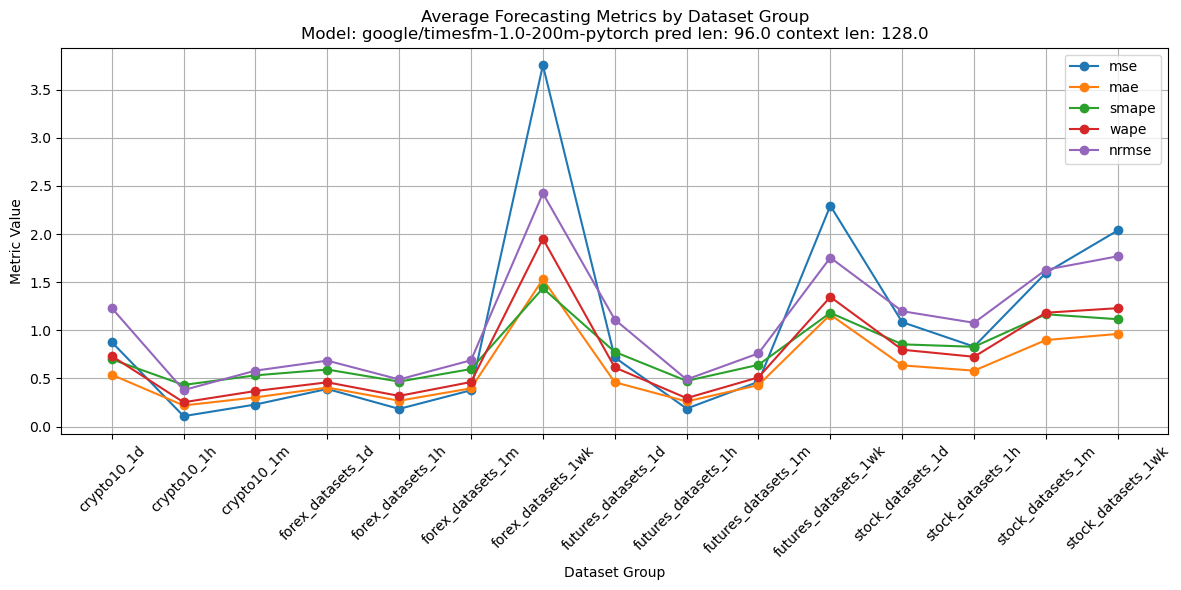


🔢 Total number of results.json files found: 908
✅ Excel updated for model(s): timesfm 200m
Saved to: C:\Users\11320\OneDrive\AI\ffm_sync\Zeroshot results - test.xlsx


In [9]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_200m_of1\h96")
show_results(root_dir)

#data load into excel
target_model = "TimesFM 200M"
fill_excel_from_result_df(summary_df, excel_path=excel_file_path, output_path=excel_file_path, target_model=target_model)

## TimesFM 500m

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_500m_of1\h10")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_500m_of1\h20")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_500m_of1\h30")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_500m_of1\h60")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_500m_of1\h96")
show_results(root_dir)

## Chronos Small

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_small_of1\h10")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_small_of1\h20")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_small_of1\h30")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_small_of1\h60")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_small_of1\h96")
show_results(root_dir)

## Chronos Medium

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_medium_of1\h10")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_medium_of1\h20")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_medium_of1\h30")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_medium_of1\h60")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_medium_of1\h96")
show_results(root_dir)

## Chronos Large

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_Large_of1\h10")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_Large_of1\h20")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_Large_of1\h30")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_Large_of1\h60")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"")
show_results(root_dir)